![header](../figures/logos_partenaires._cmems_se.jpg)

# Western Mediterranean: BFN-QG sea surface height maps
 

***
**Authors:**  CLS & Datlas <br>
**Copyright:** 2023 CLS & Datlas <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h1><center>Western Mediterranean: BFN-QG sea surface height maps</center></h1>
<h5> The notebook aims to evaluate the sea surface height maps produced by the DUACS system. </h5>
    <h5> These maps are equivalent to the SEALEVEL_GLO_PHY_L4_MY_008_047 product distributed by the Copernicus Marine Service, except that a nadir altimeter (SARAL/Altika, SEALEVEL_GLO_PHY_L3_MY_008_062 product) has been excluded from the mapping. </h5>
        <h5> We provide below a demonstration of the validation of these maps against the independent SSH data from the Saral/AltiKa altimeter distributed by CMEMS </h5>
</div>

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
***


<div class="alert alert-danger" role="alert">

<h3>Learning outcomes</h3>

At the end of this notebook you will know:
<ul>
  <li>How you can evaluated sea surface height maps with independent alongtrack data: statistical and spectral analysis</li>
</ul>
    
</div>

In [1]:
from glob import glob
import numpy as np
import os

In [2]:
import sys
sys.path.append('..')
from src.mod_plot import *
from src.mod_stat import *
from src.mod_spectral import *
from src.mod_interp import *

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

<div class="alert alert-info" role="alert">

<h2>0. Parameters</h2>

</div>

In [4]:
time_min = '2019-01-15'                                        # time min for analysis
time_max = '2019-12-15'                                        # time max for analysis
output_dir = '../results'                                      # output directory path
os.system(f'mkdir -p {output_dir}')

# Gulf Stream region
region = 'WM'
lon_min = 1                                          # domain min longitude
lon_max = 20                                          # domain max longitude
lat_min = 30.                                          # domain min latitude
lat_max = 45.                                          # domain max latitude
box_lonlat_WM = {'lon_min':lon_min,'lon_max':lon_max,'lat_min':lat_min,'lat_max':lat_max}

method_name = 'BFNQG'

stat_output_filename = f'{output_dir}/stat_sla_'+method_name+'_WM.nc'  # output statistical analysis filename
lambda_min = 65.                                               # minimun spatial scale in kilometer to consider on the filtered signal
lambda_max = 500.                                              # maximum spatial scale in kilometer to consider on the filtered signal
psd_output_filename = f'{output_dir}/psd_sla_'+method_name+'_WM.nc'    # output spectral analysis filename
segment_lenght = 1000.                                         # spectral parameer: along-track segment lenght in kilometer to consider in the spectral analysis

<div class="alert alert-info" role="alert">

<h2>1. Input files</h2>

</div>

## Sea Surface Height from Saral/AltiKa

In [5]:
%%time
list_of_file = sorted(glob('../data/independent_alongtrack/alg/2019/dt_*'))
ds_alg = xr.open_mfdataset(list_of_file, combine='nested', concat_dim='time')
ds_alg = ds_alg.where((ds_alg.time >= np.datetime64(time_min)) & (ds_alg.time <=  np.datetime64(time_max)), drop=True)
ds_alg = ds_alg.sortby('time')
ds_alg

CPU times: user 1min 2s, sys: 6.99 s, total: 1min 9s
Wall time: 1min 27s


<xarray.Dataset>
Dimensions:         (time: 13144851)
Coordinates:
  * time            (time) datetime64[ns] 2019-01-15T00:00:01.052876032 ... 2...
    longitude       (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(45359,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    ocean_tide      (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    internal_tide   (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(45359,), meta=np.ndarray>
    tpa_correction  (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P24H11M29.716548S
    time_coverage_end:               2019-01-01T23:36:52Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2018-12-31T23:25:22Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## Sea Surface Height maps to evaluate

In [6]:
%%time
list_of_maps = sorted(glob('../data/maps/DC_MapGlob_MedZoom_BFNQG/*.nc'))
ds_maps = xr.open_mfdataset(list_of_maps, combine='nested', concat_dim='time')
ds_maps = ds_maps.sel(time=slice(time_min, time_max))
ds_maps

CPU times: user 3.17 s, sys: 382 ms, total: 3.56 s
Wall time: 3.91 s


<xarray.Dataset>
Dimensions:  (time: 335, lat: 151, lon: 191)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-15 2019-01-16 ... 2019-12-15
  * lon      (lon) float64 1.0 1.1 1.2 1.3 1.4 1.5 ... 19.6 19.7 19.8 19.9 20.0
  * lat      (lat) float64 30.0 30.1 30.2 30.3 30.4 ... 44.6 44.7 44.8 44.9 45.0
Data variables:
    sla      (time, lat, lon) float64 dask.array<chunksize=(1, 151, 191), meta=np.ndarray>
    pv       (time, lat, lon) float64 dask.array<chunksize=(1, 151, 191), meta=np.ndarray>

## Selecting only West Mediterranean

In [7]:

from src.mod_compare import regional_zoom

ds_maps = regional_zoom(ds_maps, [box_lonlat_WM['lon_min'],box_lonlat_WM['lon_max']], [box_lonlat_WM['lat_min'],box_lonlat_WM['lat_max']], namelon='lon', namelat='lat', change_lon=True)
ds_maps

<xarray.Dataset>
Dimensions:  (time: 335, lat: 149, lon: 189)
Coordinates:
  * time     (time) datetime64[ns] 2019-01-15 2019-01-16 ... 2019-12-15
  * lon      (lon) float64 1.1 1.2 1.3 1.4 1.5 1.6 ... 19.5 19.6 19.7 19.8 19.9
  * lat      (lat) float64 30.1 30.2 30.3 30.4 30.5 ... 44.5 44.6 44.7 44.8 44.9
Data variables:
    sla      (time, lat, lon) float64 dask.array<chunksize=(1, 149, 189), meta=np.ndarray>
    pv       (time, lat, lon) float64 dask.array<chunksize=(1, 149, 189), meta=np.ndarray>

<div class="alert alert-info" role="alert">

<h2>2. Statistical & Spectral Analysis </h2>

</div>

## 2.1 Interpolate sea surface height maps onto along-track positions

In [8]:
ds_maps.lon.attrs=ds_alg.longitude.attrs
ds_maps.lat.attrs=ds_alg.latitude.attrs
ds_maps = ds_maps.rename({'lon':'longitude','lat':'latitude'})

In [9]:
ds_interp = run_interpolation(ds_maps, ds_alg)
ds_interp = ds_interp.dropna('time')
ds_interp

2023-10-05 09:36:26 INFO     fetch data from 2019-01-15 00:00:00 to 2019-02-01 00:00:00
2023-10-05 09:36:26 INFO     fetch data from 2019-01-31 00:00:00 to 2019-03-01 00:00:00
2023-10-05 09:36:27 INFO     fetch data from 2019-02-28 00:00:00 to 2019-04-01 00:00:00
2023-10-05 09:36:28 INFO     fetch data from 2019-03-31 00:00:00 to 2019-05-01 00:00:00
2023-10-05 09:36:29 INFO     fetch data from 2019-04-30 00:00:00 to 2019-06-01 00:00:00
2023-10-05 09:36:29 INFO     fetch data from 2019-05-31 00:00:00 to 2019-07-01 00:00:00
2023-10-05 09:36:30 INFO     fetch data from 2019-06-30 00:00:00 to 2019-08-01 00:00:00
2023-10-05 09:36:30 INFO     fetch data from 2019-07-31 00:00:00 to 2019-09-01 00:00:00
2023-10-05 09:36:31 INFO     fetch data from 2019-08-31 00:00:00 to 2019-10-01 00:00:00
2023-10-05 09:36:31 INFO     fetch data from 2019-09-30 00:00:00 to 2019-11-01 00:00:00
2023-10-05 09:36:32 INFO     fetch data from 2019-10-31 00:00:00 to 2019-12-01 00:00:00
2023-10-05 09:36:32 INFO     fet

<xarray.Dataset>
Dimensions:            (time: 53889)
Coordinates:
  * time               (time) datetime64[ns] 2019-01-15T04:17:21.499794176 .....
Data variables: (12/13)
    cycle              (time) float64 126.0 126.0 126.0 ... 135.0 135.0 135.0
    track              (time) float64 415.0 415.0 415.0 ... 929.0 929.0 929.0
    sla_unfiltered     (time) float32 0.14 0.171 0.083 ... 0.112 0.109 0.111
    sla_filtered       (time) float32 0.125 0.128 0.129 ... 0.122 0.116 0.11
    dac                (time) float32 0.069 0.067 0.066 ... -0.117 -0.122 -0.126
    ocean_tide         (time) float32 -0.01 -0.01 -0.01 ... 0.008 0.002 -0.004
    ...                 ...
    lwe                (time) float32 -0.038 -0.038 -0.039 ... 0.024 0.024 0.024
    mdt                (time) float32 0.015 0.013 0.012 ... -0.09 -0.091 -0.092
    tpa_correction     (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    longitude          (time) float64 19.89 19.87 19.85 ... 12.67 12.64 12.62
    latitude           (time) float64 31.28 31.34 31.4 ... 44.72 44.78 44.84
    msla_interpolated  (time) float64 0.1112 0.1126 0.1163 ... 0.115 0.1181

In [24]:
np.sqrt(np.nanmean((ds_interp.sla_unfiltered-ds_interp.msla_interpolated)**2))

0.02679070330778967

## 2.2 Compute grid boxes statistics & statistics by regime (coastal, offshore low variability, offshore high variability)

Once the maps have been interpolated to the position of the along-track, it is possible to calculate different statistics on the time series SLA_alongtrack and SLA_maps. 

We propose below the following statistics: error variance maps (static by 1°x1° box), explained variance maps, temporal evolution of global error variance and explained variance. 

These statistics are also applied to the filtered signals focusing on the 65-500km scale range. A bandpass filter is applied before calculating the scores.  

In [10]:
compute_stat_scores(ds_interp, lambda_min, lambda_max, stat_output_filename,method_name)

2023-10-05 09:36:34 INFO     Compute mapping error all scales
2023-10-05 09:36:34 INFO     Compute mapping error for scales between 65.0 and 500.0 km
2023-10-05 09:36:35 INFO     Compute binning statistics
2023-10-05 09:36:38 INFO     Compute statistics by oceanic regime
2023-10-05 09:37:00 INFO     Stat file saved as: ../results/stat_sla_BFNQG_WM.nc


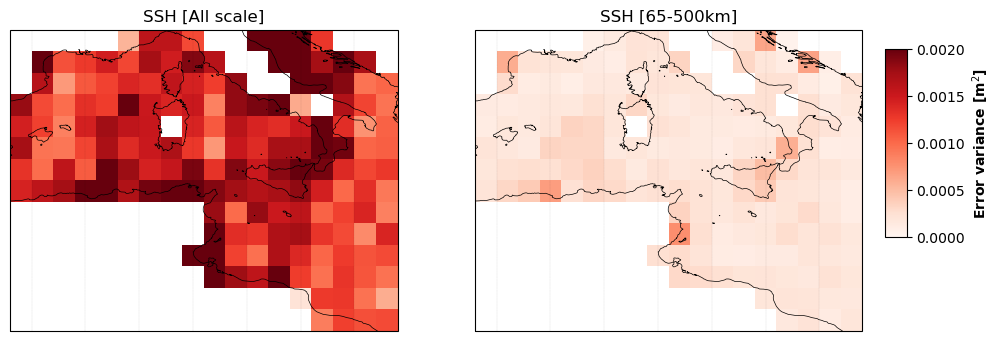

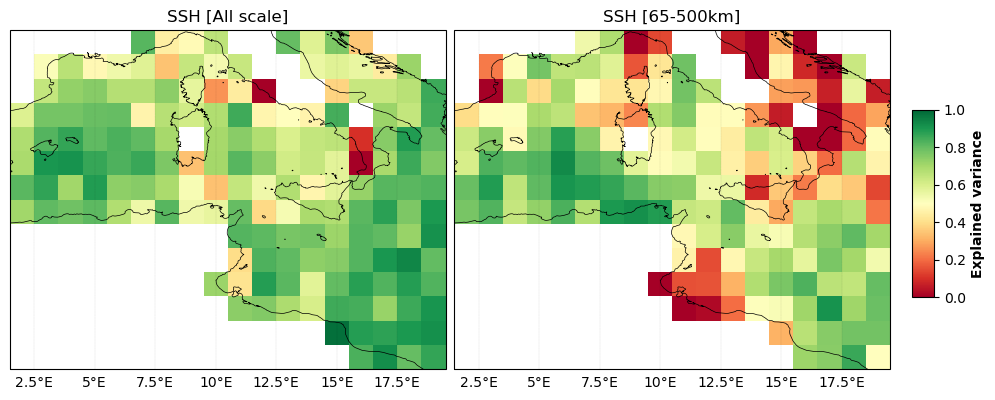

In [11]:
# Plot gridded stats
# Hvplot
# plot_stat_score_map(stat_output_filename)
# Matplotlib
plot_stat_score_map_png(stat_output_filename,region=region,box_lonlat=box_lonlat_WM)

In [12]:
plot_stat_score_timeseries(stat_output_filename)

:Layout
   .Overlay.I  :Overlay
      .Curve.All_scale :Curve   [time]   (timeserie_variance_mapping_err)
      .Curve.Filtered  :Curve   [time]   (timeserie_variance_mapping_err)
   .Overlay.II :Overlay
      .Curve.All_scale :Curve   [time]   (explained_variance_score)
      .Curve.Filtered  :Curve   [time]   (explained_variance_score)

In [13]:
plot_stat_by_regimes(stat_output_filename)

,mapping_err_var [m²],sla_unfiltered_var [m²],mapping_err_filtered_var [m²],sla_filtered_var [m²],var_score_allscale,var_score_filtered
coastal,0.001529,0.006303,0.000206,0.000747,0.757476,0.724094
offshore_highvar,NaN,NaN,NaN,NaN,NaN,NaN
offshore_lowvar,0.001164,0.008448,0.000169,0.000708,0.862184,0.761306
equatorial_band,NaN,NaN,NaN,NaN,NaN,NaN
arctic,NaN,NaN,NaN,NaN,NaN,NaN
antarctic,NaN,NaN,NaN,NaN,NaN,NaN


## 2.3 Compute Spectral scores

In [14]:
compute_psd_scores_v2(ds_interp, psd_output_filename, lenght_scale=segment_lenght,method_name=method_name)

2023-10-05 09:37:12 INFO     Segment computation...
2023-10-05 09:37:12 INFO     Spectral analysis...
2023-10-05 09:37:15 INFO     Saving ouput...
2023-10-05 09:37:20 INFO     PSD file saved as: ../results/psd_sla_BFNQG_WM.nc


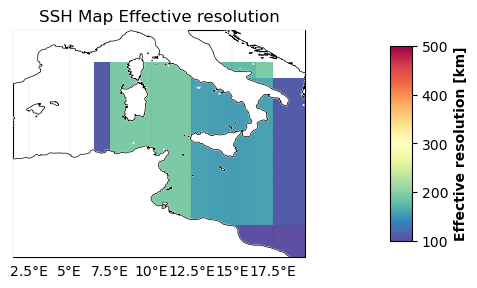

In [15]:
# Plot effective resolution
# Hvplot
# plot_effective_resolution(psd_output_filename)
# Matplotlib
plot_effective_resolution_png(psd_output_filename,region=region,box_lonlat=box_lonlat_WM)

In [18]:
ds_psd=xr.open_dataset(psd_output_filename)
ds_psd

<xarray.Dataset>
Dimensions:               (wavenumber: 72, lat: 171, lon: 360)
Coordinates:
  * wavenumber            (wavenumber) float64 0.0 0.001003 ... 0.07024 0.07124
  * lat                   (lat) float32 -80.0 -79.0 -78.0 ... 88.0 89.0 90.0
  * lon                   (lon) float32 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0
Data variables:
    nb_segment            (lat, lon) float64 ...
    psd_ref               (wavenumber, lat, lon) float64 ...
    psd_study             (wavenumber, lat, lon) float64 ...
    psd_diff              (wavenumber, lat, lon) float64 ...
    effective_resolution  (lat, lon) float64 ...
    coherence             (wavenumber, lat, lon) float64 ...
    cross_spectrum_real   (wavenumber, lat, lon) float64 ...
    cross_spectrum_imag   (wavenumber, lat, lon) float64 ...
Attributes:
    method:   BFNQG

In [19]:
ds_psd=xr.open_dataset(psd_output_filename)
wavenum = np.array(ds_psd.wavenumber)
psd_ref = np.mean(np.mean(ds_psd.psd_ref,2),1)
psd_study = np.mean(np.mean(ds_psd.psd_study,2),1)

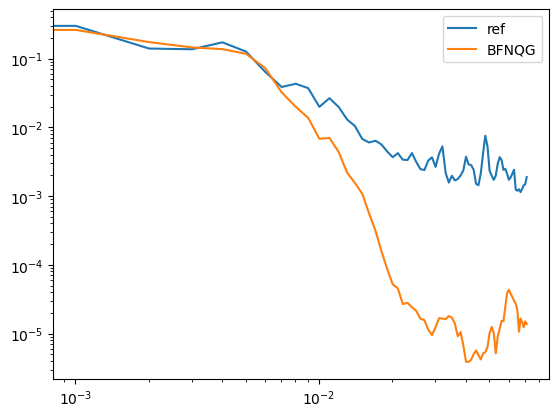

In [21]:
plt.loglog(wavenum,psd_ref,label='ref')
plt.loglog(wavenum,psd_study,label='BFNQG')
plt.legend()

In [16]:
plot_psd_scores(psd_output_filename)

:Layout
   .DynamicMap.I   :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_alongtrack   :Curve   [wavelenght]   (psd_ref)
         .Curve.NOISE_alongtrack :Curve   [wavelenght]   (noise)
         .Curve.PSD_map          :Curve   [wavelenght]   (psd_study)
         .Curve.PSD_err          :Curve   [wavelenght]   (psd_diff)
   .DynamicMap.II  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.PSD_map_over_PSD_ref :Curve   [wavelenght]   (psd_ratio)
         .Curve.I                    :Curve   [wavelenght]   (coherence)
   .DynamicMap.III :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (psd_score)
         .Curve.II :Curve   [wavelenght]   (coherence)
   .DynamicMap.IV  :DynamicMap   [lon,lat]
      :Overlay
         .Curve.I  :Curve   [wavelenght]   (coherence)
         .Curve.II :Curve   [wavelenght]   (coherence)

The interactive plot above allows you to explore the spectral metrics by latitude / longitude box